# scipy curve_fit

In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [ ]:
def gauss(x, *p):    
    (b, A, xc, w,) = p
    return b + A * np.exp(-(x - xc) ** 2 / (2.0 * w ** 2))


def gauss_(x, *p):    
    (b, A, xc, w,) = p
    return b + A * np.exp(-(x - xc) ** 2 / (2.0 * w ** 2))



In [ ]:
(b, A, xc, w,) = ( 0, 1, .5, .2)

In [ ]:
x = np.linspace(0,1, 100)
data = gauss(x, b, A, xc, w) + .1* np.random.random( 100 )

In [ ]:
#np.random.random( 100 )

In [ ]:
fig, ax = plt.subplots()
ax.plot( x, data)

In [ ]:
p0 = ( 0, 1, .5, .2)

In [ ]:
(coeff, var_matrix,) = curve_fit(gauss, x,data, p0=p0)

In [ ]:
fits = gauss(x, *coeff) 

In [ ]:
fig, ax = plt.subplots()
ax.plot( x, data)
ax.plot(x, fits, 'r-')

# lmfit

In [ ]:
from lmfit import  Model
from lmfit import minimize, Parameters, Parameter, report_fit

In [ ]:
def gauss(x, b, A, xc, w):    
    #(b, A, xc, w,) = p
    return b + A * np.exp(-(x - xc) ** 2 / (2.0 * w ** 2))

#p0 = ( 0, 1, .5, .2)


In [ ]:
x = np.linspace(0,1, 100)
data = gauss(x, b, A, xc, w) + .1* np.random.random( 100 )

In [ ]:
mod = Model(  gauss )

In [ ]:
pars  = mod.make_params( b=0, A = 1, xc=0.5, w=.2)

In [ ]:
mod.set_param_hint( 'A',   min=0, max= 10 )
mod.set_param_hint( 'b',   min=0  )
#mod.set_param_hint( 'A',   min=0, max= 10 )

In [ ]:
pars['A'].vary = True #False

In [ ]:
pars

In [ ]:
result = mod.fit(data, pars, x = x )

In [ ]:
print( result.fit_report() )

In [ ]:
result.best_values['A']

In [ ]:
fig, ax = plt.subplots()
ax.plot( x, data)
ax.plot(x, result.best_fit, 'r-')

In [ ]:
#report_fit( result )

## lmfit, minimize

In [ ]:
from lmfit import  Model
from lmfit import Minimizer, minimize, Parameters, Parameter, report_fit

In [ ]:
def gauss(x, paras):    
    #(b, A, xc, w,) = p
    para = paras.valuesdict() 
    (b, A, xc, w) = para['b'], para['A'],para['xc'], para['w']
    return b + A * np.exp(-(x - xc) ** 2 / (2.0 * w ** 2))


def gauss_residual( paras, x, data):   
    
    para = paras.valuesdict() 
    (b, A, xc, w) = para['b'], para['A'],para['xc'], para['w']
    #print( b )
    model = b + A * np.exp( -(x - xc) ** 2 / (2.0 * w ** 2) )
    return model- data



In [ ]:
(b, A, xc, w,) = ( 0, 1, .5, .2)

In [ ]:
x = np.linspace(0,1, 100)
data = gauss_(x, b, A, xc, w) + .1* np.random.random( 100 )

In [ ]:
params = Parameters()
params.add('b',   value= 0,  min=-1)
params.add('A', value= 1)
params.add('xc', value= 0.5, min=-1, max=1)
params.add('w', value= .2)


In [ ]:
#minimize(gauss_residual, params, method='leastsq', args=(x, data), kws={'options': {'maxiter':10}}, 
#         scale_covar=True, iter_cb=None, )

In [ ]:
#minner = Minimizer(gauss_residual, params, fcn_args=(x, data))
#kws  = {'options': {'maxiter':10}}
#result = minner.minimize()

In [ ]:
result = minimize(gauss_residual, params, args=(x,data),  method='leastsq')

In [ ]:
#out = minimize(gauss_residual, params, args=(x,), kws={'data':data}, method='leastsq')

In [ ]:
result.values

In [ ]:
result.chisqr

In [ ]:
#result.params

In [ ]:
fig, ax = plt.subplots()
ax.plot( x, data)
ax.plot(x, gauss( x, result.params), 'r-')

In [ ]:
report_fit( result )

# likelyhood fit

In [5]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [6]:
def save_data_to_h5(  data_dir, filename, *argv,**kwargs):   
    '''
    save array to h5 file
    '''
    import h5py    
    with h5py.File(data_dir + '%s.h5'%filename, 'w') as hf:  
        for k in kwargs:
            hf.create_dataset(k, data = kwargs[k]  )            
            
def load_h5( data_dir, filename, *argv,**kwargs):   
    ''' 
       load results from a h5 file
    '''
    import h5py
    import numpy as np
    d = {}
    with h5py.File(data_dir + '%s.h5'%filename, 'r') as hf:         
        for k in list( hf.keys() ):
            d[k] = np.array( hf[k]  )
    return d         

In [7]:
import numpy as np
from scipy.stats import nbinom
def _ll_nb2(y, X, beta, alph):
     mu = np.exp(np.dot(X, beta))
     size = 1 / alph
     prob = size / (size + mu)
     ll = nbinom.logpmf(y, size, prob)
     return ll


In [18]:
from statsmodels.base.model import GenericLikelihoodModel


class NBin(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NBin, self).__init__(endog, exog, **kwds)
        
    def nloglikeobs(self, params):
        alph = params[-1]
        beta = params[:-1]
        print( _ll_nb2 )
        ll = _ll_nb2(self.endog, self.exog, beta, alph)
        return -ll
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params == None:
            # Reasonable starting values
            start_params = np.append(np.zeros(self.exog.shape[1]), .5)
            start_params[0] = np.log(self.endog.mean())
        return super(NBin, self).fit(start_params=start_params,
                                       maxiter=maxiter, maxfun=maxfun,**kwds)

In [19]:
data_dir = '/XF11ID/analysis/2016_3/commissioning/Results/fdab74/'
filename='test'

In [20]:
data =  load_h5( data_dir, filename='test1' )

In [21]:
x,y = data['x'], data['y']

In [22]:
#mod = NBin(y, x)

In [23]:
#mod.fit()

In [91]:
stats.norm.logpdf?

In [172]:
from scipy.special import gamma, gammaln
from scipy import stats



def nbinom_dist(bin_values, K, M):
    co_eff = np.exp(gammaln(bin_values + M) -
                    gammaln(bin_values + 1) - gammaln(M))
    nbinom = co_eff * np.power(M / (K + M), M) * np.power(K / (M + K), bin_values)    
    return nbinom


def nbinom_lnlike(paras, x, data):
    K,M = paras
    w= np.where(data)[0]
    model =  nbinom_dist(x[w], K, M)  #get the expected photon count    
    return   -2* np.sum( data[w] * np.log( model/data[w]  )   )






def nbinom_lnlike2(paras, x, data):
    K,M = paras
    model =  nbinom_dist(x, K, M)  #get the expected photon count    
    return  -np.sum( stats.norm.logpdf(data, loc= model  ) )

def nbinom_lnlike(paras, x, data):
    K,M = paras
    w= np.where(data)[0]
    model =  nbinom_dist(x[w], K, M)  #get the expected photon count    
    return   -2* np.sum( data[w] * np.log( model/data[w]  )   )




 

from lmfit import  Model
from scipy.interpolate import UnivariateSpline

n_mod = Model(nbinom_dist)


In [165]:
w = np.where(x)[0]

In [166]:
x[w]

array([    1,     2,     3, ..., 31740, 31741, 31742])

In [171]:
 nbinom_lnlike([2.6, 10], x, y)

0.0083879027694322237

In [ ]:
from scipy.special import gamma, gammaln
from scipy.optimize import minimize
from scipy import stats


def nbinom_dist(bin_values, K, M):
    co_eff = np.exp(gammaln(bin_values + M) -
                    gammaln(bin_values + 1) - gammaln(M))
    nbinom = co_eff * np.power(M / (K + M), M) * np.power(K / (M + K), bin_values)    
    return nbinom

def nbinom_lnlike2(paras, x, data):
    K,M = paras
    model =  nbinom_dist(x, K, M)  #get the expected photon count    
    return  -np.sum( stats.norm.logpdf(data, loc= model  ) )

def nbinom_lnlike(paras, x, data):
    K,M = paras
    w= np.where(data)[0]
    model =  nbinom_dist(x[w], K, M)  #get the expected photon count    
    return   -2* np.sum( data[w] * np.log( model/data[w]  )   )


#x is the histogram bin
#y is the histogram
#x0=[K,M], K is the average photon count, 1/M is contrast

resultL = minimize(nbinom_lnlike,  x0= [  2, 10], args=(x, y), method= 'BFGS', options={'disp': True} ) 



In [189]:
nbinom_lnlike2([2,6], x,y)

29169.871447638092

In [192]:
nbinom_lnlike([2.6,10], x,y)

0.0083879027694322237

In [193]:
nbinom_lnlike([2.6,5.8], x,y)

0.00032188699020797894

In [158]:
len(y), len(x)

(31743, 31743)

In [120]:
import scipy.stats as ss
import scipy.optimize as so

#define a likelihood function
def likelihood_f(P, x, neg=1):
    n=np.round(P[0]) #by definition, it should be an integer 
    p=P[1]
    loc=np.round(P[2])
    return neg*(np.log(ss.nbinom.pmf(x, n, p, loc))).sum()

#generate a random variable
X=ss.nbinom.rvs(n=100, p=0.4, loc=0, size=1000)

In [149]:
#his = np.bincount(X, minlength=  max(X))

In [152]:
#fig,ax = plt.subplots()
#ax.plot( X )


In [92]:
ss.nbinom.pmf?

In [115]:
#The likelihood
likelihood_f([100,0.4,0], X)

-4400.9650352648405

In [116]:
 
#A simple fit, the fit is not good and the parameter estimate is way off
result=so.fmin(likelihood_f, [50, 1, 1], args=(X,-1), full_output=True, disp=False)

In [117]:
P1=result[0]
(result[1], result[0])

(4417.5228234861506, array([ 59.58631491,   0.28772818,   1.15425027]))

In [72]:
 
#Try a different set of start paramters, the fit is still not good and the parameter estimate is still way off
result=so.fmin(likelihood_f, [50, 0.5, 0], args=(X,-1), full_output=True, disp=False)
P1=result[0]
(result[1], result[0])

(4409.2346205735876,
 array([  6.24808989e+01,   2.92620002e-01,   6.45460010e-04]))

In [73]:
 
#In this case we need a loop to get it right
result=[]
for i in range(40, 120): #in fact (80, 120) should probably be enough
    _=so.fmin(likelihood_f, [i, 0.5, 0], args=(X,-1), full_output=True, disp=False)
    result.append((_[1], _[0]))

In [74]:
P2=sorted(result, key=lambda x: x[0])[0][1]
sorted(result, key=lambda x: x[0])[0]

(4390.2268946290296,
 array([  9.59380491e+01,   3.90435927e-01,   3.08731921e-04]))

<IPython.core.display.Javascript object>


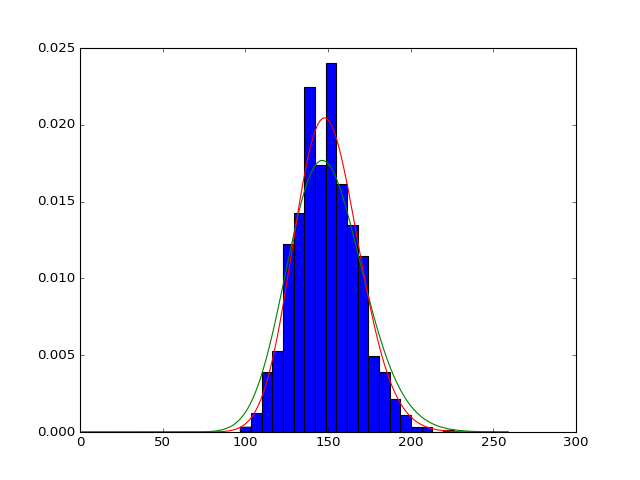

In [130]:
fig,ax = plt.subplots()
#Which one is visually better?
ax.hist(X, bins= 20, normed=True)
ax.plot(range(260), ss.nbinom.pmf(range(260), np.round(P1[0]), P1[1], np.round(P1[2])), 'g-')
ax.plot(range(260), ss.nbinom.pmf(range(260), np.round(P2[0]), P2[1], np.round(P2[2])), 'r-')


In [ ]:
from scipy.optimize import minimize

In [86]:
resultL

 final_simplex: (array([[ 2.60661731,  6.29676419],
       [ 2.6066175 ,  6.2968324 ],
       [ 2.60662734,  6.29683559]]), array([ 29169.86586353,  29169.86586353,  29169.86586353]))
           fun: 29169.86586353146
       message: 'Optimization terminated successfully.'
          nfev: 89
           nit: 46
        status: 0
       success: True
             x: array([ 2.60661731,  6.29676419])

In [186]:
m0 = 10
#m0= 10 * j**1.2

result_n = n_mod.fit( y, bin_values=x, K= 2, M= m0 )  

resultL = minimize(nbinom_lnlike,  x0= [  2, m0], args=(x, y), method= 'BFGS', options={'disp': True} ) 
#resultL = minimize(nbinom_lnlike,  x0= [  2, m0], args=(x, y), method='nelder-mead', options={'disp': True} ) 

#resultL= so.fmin(nbinom_lnlike, x0= [  2, m0], args=(x, y), full_output=True,  disp=True )

 

m,k = result_n.best_values['M'], result_n.best_values['K']
ml, kl = resultL['x'][1], resultL['x'][0] 


print(  m0,result_n.best_values['M'],resultL['x'][1] )

Optimization terminated successfully.
         Current function value: 0.000223
         Iterations: 16
         Function evaluations: 76
         Gradient evaluations: 19
10 6.29671630855 5.9917710683


In [182]:
k, kl, m, ml, m0

(2.6066229192016421,
 2.6142754540386477,
 6.2967173033657371,
 5.9915406839424357,
 60)

In [183]:
y

array([ 0.11392293,  0.20615   ,  0.22315486, ...,  0.        ,
        0.        ,  0.        ])

<IPython.core.display.Javascript object>


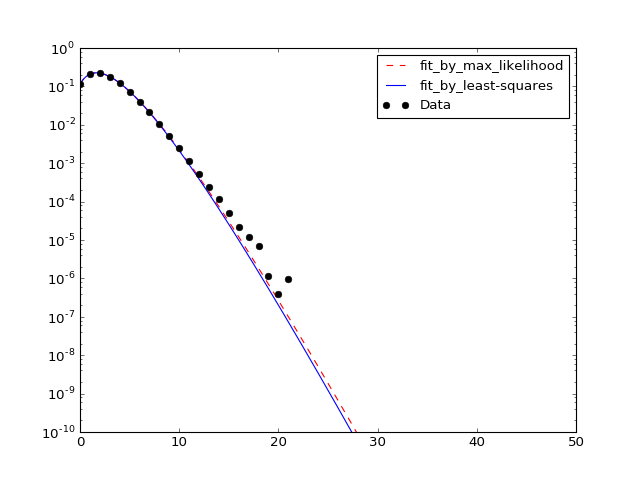

In [184]:
max_cts = 100

fitx = np.linspace(0, max_cts, 5000     )
fitx_ = fitx #/ xscale  
        
fity = nbinom_dist( fitx, k,m )  
fitL = nbinom_dist( fitx, kl,ml )  

fig, ax = plt.subplots()
ax.semilogy( fitx_,fitL,  "--r", label='fit_by_max_likelihood') 
ax.semilogy( fitx_,fity,  "-b",  label='fit_by_least-squares') 
ax.plot( x, y,"ko", label='Data')

ax.set_xlim(0, 50)
ax.set_ylim(1e-10, 1)
ax.legend(loc='best', fontsize = 12)

In [ ]:
import numpy as np
import scipy as sp
import scipy.stats as st
from scipy.optimize import leastsq
#
def nbinomlog(p, hist, x, N):
    """ Residuals for maximum likelihood fit to nbinom distribution.
        Vary M (shape param) and mu (count rate) vary (using leastsq)"""
    mu,M = p
    mu=abs(mu)
    w=np.where(hist>0.0);
    Np=N * st.nbinom.pmf(x,M,1.0/(1.0+mu/M))
    err=2*(Np-hist)
    err[w] = err[w] - 2*hist[w]*np.log(Np[w]/hist[w])#note: sum(Np-hist)==0
    return np.sqrt(err)

def nbinomlog1(p, hist, x, N,mu):
    """ Residuals for maximum likelihood fit to nbinom distribution.
        Vary M (shape param) but mu (count rate) fixed (using leastsq)"""
    M = abs(p[0])
    w=np.where(hist>0.0);
    Np=N * st.nbinom.pmf(x,M,1.0/(1.0+mu/M))
    err=2*(Np-hist)
    err[w] = err[w] - 2*hist[w]*np.log(Np[w]/hist[w])#note: sum(Np-hist)==0
    return np.sqrt(err)


def nbinomres(p, hist, x, N):
    ''' residuals to leastsq() to fit normal chi-square'''
    mu,M = p
    Np=N * st.nbinom.pmf(x,M,1.0/(1.0+mu/M))
    err = (hist - Np)/np.sqrt(Np)
    return err

def fitpr(plsq,lbl=None):
    ''' nicely print out results of a fit '''
    #get fitted results.
    mu=plsq[0]
    if(lbl==None):
        lbl=[]
        for i in np.arange(mu.size):
            lbl.append('A%(#)02d'%{'#':i})
    #get error bars 
    sigma = np.sqrt(np.diag(plsq[1]))
    #get chi sq.
    chisq = sum(plsq[2]['fvec']**2)
    #print resuls of a fit.
    print('   chisq=%(c).4f'%{'c':chisq})
    for i in np.arange(mu.size):
        print('     %(lbl)8s =%(m)10.4f +/- %(s)10.4f'%{'lbl':lbl[i],'m':mu[i],'s':sigma[i]})

In [211]:
nn=35;N=1000
M=11.; mu=3.3
x=np.arange(0,nn)
#generate some fake data
data = st.nbinom.rvs(M,1./(1.0+mu/M),size=N)

h=np.histogram(data,bins=np.arange(0,nn+1))[0]

In [231]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [232]:
len(h)

35

In [212]:
h.shape

(35,)

<IPython.core.display.Javascript object>


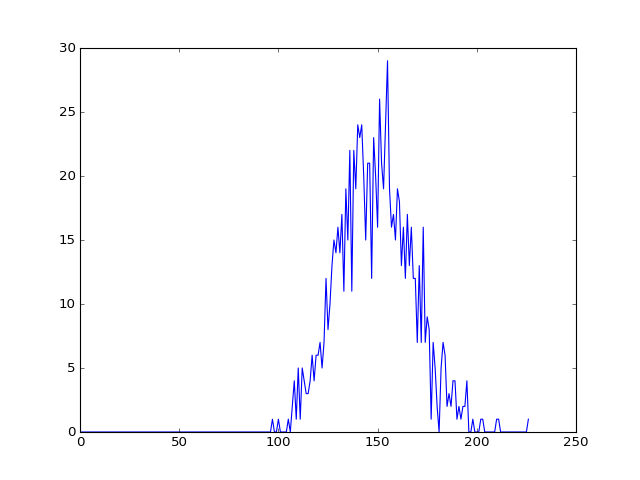

In [213]:
fig,ax=plt.subplots()
ax.plot(his)
#ax.plot(data)

In [ ]:
resultL = minimize(nbinom_lnlike,  x0= [  2, m0], args=(x, y), method= 'BFGS', options={'disp': True} ) 



In [227]:
p0 = [4.3, 15.]
#fit by normal chi-square
plsq = leastsq(nbinomres, p0, args=(h, x, N),full_output=1)
mu_meas=sum(h*x)/np.float32(N)
print('avg(mu)=%(a).4f +/- %(s).4f M=%(m)d on %(p)d pts '%{'a':mu_meas,'s':np.sqrt(mu/N),'m':M,'p':sum(h!=0)})
sigma= np.sqrt(np.diag(plsq[1]))
print('norm:')
fitpr(plsq,lbl=['mu','M'])

avg(mu)=3.2930 +/- 0.0584 M=6 on 14 pts 
norm:
   chisq=18.3508
           mu =    3.3136 +/-     0.0677
            M =    8.5543 +/-     1.4139


In [206]:
plsq[0] 

array([ 3.40546479,  6.64515809])

In [210]:
len(his)

227

In [218]:
N

1000

<IPython.core.display.Javascript object>


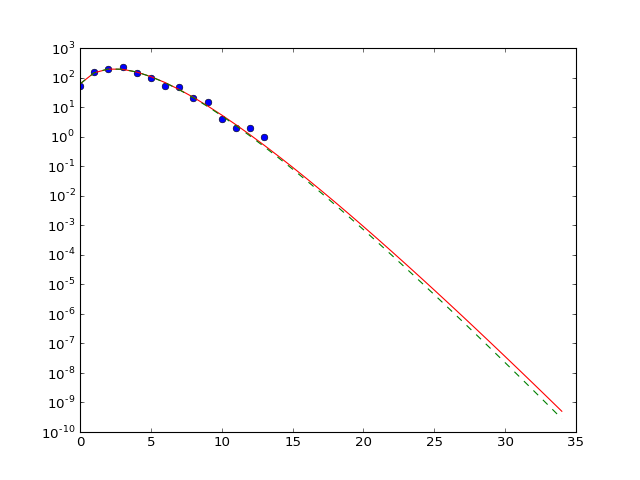

In [230]:
fig,ax=plt.subplots()
ax.plot(h, 'bo')
mu, M = plsq[0]
ax.semilogy(   N* st.nbinom.pmf(x,M,1.0/(1.0+mu/M)), '-r'    )
mu, M = plsqm[0]
ax.semilogy(   N* st.nbinom.pmf(x,M,1.0/(1.0+mu/M)), '--g'    )

In [ ]:
N * st.nbinom.pmf(x,M,1.0/(1.0+mu/M))

In [204]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

array([ 3.29300012,  8.91077222])

In [226]:
#maximum log likelihood: note mu varying
#also by trial and error: Fixing mu=average gives precisely same M and chisq.
plsqm = leastsq(nbinomlog, p0, args=(h, x,N),full_output=1)
sigma= np.sqrt(np.diag(plsqm[1]))
print(' log: ')
fitpr(  plsqm,lbl=['mu','M']  )

#maximum log likelihood: note mu fixed.
plsq_ = leastsq(nbinomlog1, [15.0], args=(h, x,N,mu_meas),full_output=1)
sigma= np.sqrt(np.diag(plsq_[1]))
print(' log: fix mu')
fitpr(plsq_,lbl=['M'])

 log: 
   chisq=18.3214
           mu =    3.2930 +/-     0.0672
            M =    8.9108 +/-     1.5368
 log: fix mu
   chisq=18.3249
            M =    8.9107 +/-     1.5356
